# A modern approach to Hopfield Neural Networks and Economic Dispatch Optimsiation

## Intent and Purpose
This notebook implements and extends a Hopfield Neural Network (HNN) approach to solve economic dispatch (ED) problems in power systems, building upon the foundational work by T. Yalcinoz, M.J. Short, and B.J. Cory in their 2001 paper, "Hopfield Neural Network Approaches to Economic Dispatch Problems" (International Journal of Electrical Power & Energy Systems, Vol. 23, No. 6, pp. 435-442). The primary intent is to provide a flexible, efficient, and scalable tool for optimizing generator outputs to minimize operational costs while meeting demand and respecting system constraints over multiple timesteps. Unlike traditional static ED solutions, this notebook introduces a dynamic, time-series perspective, leveraging modern optimization techniques to enhance performance and applicability to real-world scenarios.
The notebook simulates a power system using synthetic data inspired by Ireland's grid on January 31, 2025, scales it to user-defined generator counts and capacities, and optimizes dispatch across a 24-hour period (48 timesteps). It serves as both an educational tool to explore HNN-based optimization and a practical framework for testing ED strategies under varying conditions, extending the paper's focus on single-load-level, unconstrained, and constrained ED problems tested on systems from 3 to 240 units.

## How It Works
### Core Concept
Economic dispatch seeks to minimize the total fuel cost of power generation, expressed as:
$$ F = \sum_{i=1}^{N} F_i(P_i) = \sum_{i=1}^{N} (a_i + b_i P_i + c_i P_i^2) $$
where:
$( N )$ is the number of generators,
$( P_i )$ is the power output of the $( i )$-th generator,
$( a_i, b_i, c_i )$ are the cost coefficients,
Subject to the power balance constraint: $( \sum_{i=1}^{N} P_i = P^D + P^L )$, where $( P^D )$ is the demand and $( P^L = \sum_{i=1}^{N} B_i P_i^2 )$ is the transmission loss,
And generation limits: $( P_{\text{min},i} \leq P_i \leq P_{\text{max},i} )$.
The HNN transforms this optimization problem into an energy minimization task, where the network's energy function $( E )$ encapsulates both the cost objective and constraints.

### Hopfield Neural Network Mechanics
The HNN operates on a continuous model with dynamics governed by:

$$ \frac{d u_i}{dt} = -\frac{u_i}{\eta_i} + \sum_{j=1}^{n} T_{ij} x_j + i_i^b $$
where:

$( u_i )$ is the internal state of neuron $( i )$,
$( x_i = g(u_i) )$ is the output (generator power),
$( T )$ is the weight matrix,
$( i^b )$ is the bias vector,
$( \eta_i )$ is a decay constant (simplified in this implementation).
The energy function is:

$$ E(\mathbf{x}) = -\frac{1}{2} \mathbf{x}^T \mathbf{T} \mathbf{x} - \mathbf{x}^T \mathbf{i}^b $$

For ED, this is mapped to:
$$ E = E^{\text{obj}} + \frac{c_0}{2} \left\| \mathbf{A}^{\text{eq}} \mathbf{x} - \mathbf{b}^{\text{eq}} \right\|^2 $$

where:

$( E^{\text{obj}} = \frac{1}{2} \mathbf{x}^T \mathbf{T}^{\text{obj}} \mathbf{x} + \mathbf{x}^T \mathbf{i}^{\text{obj}} )$ represents the cost function,
$( \mathbf{T}^{\text{obj}}_{ii} = -2 c_i )$, $( \mathbf{i}^{\text{obj}}_i = -b_i )$,
The penalty term enforces $( \sum P_i = P^D + P^L )$ with $( c_0 )$ as the penalty weight,
Side constraints are handled via a modified activation function:

$$ x_i = g(x_i) = \begin{cases}
P_{\text{min},i} & \text{if } x_i < P_{\text{min},i} \\
x_i & \text{if } P_{\text{min},i} \leq x_i \leq P_{\text{max},i} \\
P_{\text{max},i} & \text{if } x_i > P_{\text{max},i}
\end{cases} $$

The network evolves by updating $( \mathbf{x} )$ using a projected gradient method, ensuring feasibility with:

$$ \mathbf{x} = \mathbf{T}^{\text{constr}} \mathbf{x} + \mathbf{s} $$

where $( \mathbf{T}^{\text{constr}} = \mathbf{I} - \mathbf{A}^{\text{eq}^T} (\mathbf{A}^{\text{eq}} \mathbf{A}^{\text{eq}^T})^{-1} \mathbf{A}^{\text{eq}} )$ and $( \mathbf{s} = \mathbf{A}^{\text{eq}^T} (\mathbf{A}^{\text{eq}} \mathbf{A}^{\text{eq}^T})^{-1} \mathbf{b}^{\text{eq}} )$.

### Implementation and Extensions
The notebook builds two main classes:

- **DataGenerator**: Creates synthetic data (generator capacities, costs, and a 48-timestep demand profile) based on Irish grid data, scaled to user-defined parameters.
- **HopfieldEconomicDispatch**: Solves the ED problem over multiple timesteps using an enhanced HNN.
Key extensions beyond the Yalcinoz et al. paper include:
- **Multi-Timestep Optimization**: The paper focuses on single-load-level ED (e.g., 3 to 240 units), whereas this notebook optimizes over 48 timesteps, capturing daily demand variations from Ireland's grid data.
- **Advanced Optimizers**: Incorporates RAdam (Rectified Adam) and Lookahead algorithms to accelerate convergence and stabilize solutions, replacing the paper’s simpler projected gradient updates with dynamic time steps ( $( \Delta t = -\frac{\mathbf{r}^T \mathbf{r}}{\mathbf{r}^T \mathbf{T}^{\text{obj}} \mathbf{r}} )$, where $( \mathbf{r} = \mathbf{s} - \mathbf{T}^{\text{constr}} \mathbf{x} )$ ).
- **Dynamic Loss Adjustment**: Iteratively adjusts outputs for transmission losses, unlike the paper’s static loss inclusion, improving accuracy.
- **Reduced Neuron Count**: Avoids slack variables for side constraints (used in the paper’s HN model, requiring $( n + 2n )$ neurons for $( n )$ generators), relying instead on the activation function, aligning with the paper’s FHN approach but scaled to multi-timestep contexts.
- **Visualization**: Adds plots of energy, cost, and demand fulfillment over iterations, absent in the paper, enhancing interpretability.
- **Scalability and Realism**: Tested on 40 generators but allows for larger systems, with realistic demand profiles.

### Optimization Process
The solver:
Initializes generator outputs with a noisy uniform distribution adjusted for losses.
Iterates using a projected gradient step with RAdam, calculating $( \Delta t )$ dynamically.
Applies Lookahead periodically to interpolate between fast and slow weights for stability.
Constrains outputs via the activation function.
Tracks convergence via energy, cost, and constraint penalties, stopping when changes fall below tolerances.




In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.graph_objects as go

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.graph_objects as go

class DataGenerator:
    """
    This class creates synthetic data for economic dispatch problems, mimicking real-world power systems.
    It uses a demand profile from Ireland’s grid on a specific day, scaled to the number of generators
    and their capacities, to simulate realistic generator and demand scenarios.

    Attributes:
      num_generators (int): Total number of generators in the system.
      capacities (torch.Tensor): Power capacities of each generator in MW.
      cost_coefficients (dict): Contains 'a', 'b', 'c' coefficients defining each generator’s cost function.
      transmission_loss_coeffs (torch.Tensor): Coefficients for calculating transmission losses.
      total_capacity (float): Sum of all generator capacities.
      demand_profile (torch.Tensor): Simulated daily demand profile in MW.
      demand (torch.Tensor): Working copy of the demand profile for simulations.
    """
    def __init__(self, num_generators, seed=5000, max_percentage=80, min_percentage=20):
        """
        Sets up the data generator by creating generator capacities, cost coefficients, and a demand profile.

        Args:
          num_generators (int): How many generators to simulate.
          seed (int, optional): Random seed for reproducibility. Defaults to 5000.
          max_percentage (float, optional): Max demand as a percentage of total capacity. Defaults to 80.
          min_percentage (float, optional): Min demand as a percentage of total capacity. Defaults to 20.

        What it does:
          - Generates generator capacities based on real Irish grid data with some randomness for variety.
          - Assigns cost coefficients ('a', 'b', 'c') with a bias toward cheaper operation for larger generators.
          - Creates transmission loss coefficients to simulate power losses.
          - Scales a real demand profile from Ireland to match the system’s total capacity.
        """
        self.num_generators = num_generators
        np.random.seed(seed)

        # Use real-world Irish generator capacities as a starting point
        observed_capacities = np.array([90, 90, 90, 431, 402, 61, 118, 58, 58, 464, 339, 397, 17, 91, 285, 285, 285, 104, 463, 52, 52, 81, 81, 54, 54, 241, 243, 52, 52, 386, 137, 444])

        # Create a probability distribution from observed capacities
        unique_capacities, counts = np.unique(observed_capacities, return_counts=True)
        probabilities = counts / len(observed_capacities)

        # Generate capacities for the specified number of generators
        self.capacities = np.random.choice(unique_capacities, size=self.num_generators, p=probabilities)
        self.capacities = np.round(self.capacities * np.random.uniform(0.9, 1.1, self.num_generators)).astype(int)
        self.capacities = np.maximum(self.capacities, 1)

        # Set up cost coefficients, favoring larger generators with lower costs
        self.cost_coefficients = {'a': np.zeros(self.num_generators), 'b': np.zeros(self.num_generators), 'c': np.zeros(self.num_generators)}
        for i in range(self.num_generators):
            if self.capacities[i] > 250:  # Larger generators get lower costs
                self.cost_coefficients['a'][i] = np.random.uniform(3, 10)
                self.cost_coefficients['b'][i] = np.random.uniform(10, 15)
                self.cost_coefficients['c'][i] = np.random.uniform(0.001, 0.005)
            else:  # Smaller generators have higher costs
                self.cost_coefficients['a'][i] = np.random.uniform(15, 30)
                self.cost_coefficients['b'][i] = np.random.uniform(15, 20)
                self.cost_coefficients['c'][i] = np.random.uniform(0.005, 0.01)

        # Generate coefficients for transmission losses
        self.transmission_loss_coeffs = np.random.uniform(0.00001, 0.0001, self.num_generators)

        # Convert all data to PyTorch tensors for computation
        self.capacities = torch.tensor(self.capacities, dtype=torch.double)
        self.a = torch.tensor(self.cost_coefficients['a'], dtype=torch.double)
        self.b = torch.tensor(self.cost_coefficients['b'], dtype=torch.double)
        self.c = torch.tensor(self.cost_coefficients['c'], dtype=torch.double)
        self.B = torch.tensor(self.transmission_loss_coeffs, dtype=torch.double)

        # Calculate total system capacity
        self.total_capacity = self.capacities.sum()

        # Load and scale a real demand profile from Ireland (Jan 31, 2025)
        original_demand = np.array([
            4630, 4630, 4585, 4585, 4480, 4480, 4363, 4363, 4287, 4287, 4324, 4324, 4274, 4274, 4224, 4224,
            4158, 4158, 4238, 4238, 4238, 4238, 4194, 4194, 4167, 4167, 4169, 4169, 4158, 4158, 4145, 4145,
            4134, 4134, 4129, 4129, 4115, 4115, 4121, 4121, 4160, 4160, 4212, 4212, 4229, 4229, 4283, 4283,
            4389, 4389, 4578, 4578, 4698, 4698, 4882, 4882, 5096, 5096, 5438, 5438, 5648, 5648, 5854, 5854,
            5899, 5899, 5960, 5960, 6014, 6014, 6066, 6066, 6131, 6131, 6202, 6202, 6196, 6196, 6189, 6189,
            6127, 6127, 6074, 6074, 6058, 6058, 6022, 6022, 5994, 5994, 5957, 5957, 5922, 5922, 5879, 5879,
            5827, 5827, 5826, 5826, 5799, 5799, 5774, 5774, 5747, 5747, 5697, 5697, 5634, 5634, 5614, 5614,
            5589, 5589, 5596, 5596, 5590, 5590, 5592, 5592, 5611, 5611, 5665, 5665, 5709, 5709, 5759, 5759,
            5798, 5798, 5867, 5867, 5947, 5947, 6025, 6025, 6117, 6117, 6256, 6256, 6423, 6423, 6508, 6508,
            6502, 6502, 6471, 6471, 6411, 6411, 6353, 6353, 6302, 6302, 6248, 6248, 6206, 6206, 6119, 6119,
            6014, 6014, 5932, 5932, 5865, 5865, 5794, 5794, 5668, 5668, 5568, 5568, 5488, 5488, 5389, 5389,
            5279, 5279, 5206, 5206, 5101, 5101, 4963, 4963, 4875, 4875, 4934, 4934, 4847, 4847, 4725, 4725
        ])

        # Resample the demand to 48 timesteps and scale it to the system’s capacity
        resampled_demand = np.interp(np.linspace(0, 191, 48), np.arange(192), original_demand)
        min_original, max_original = np.min(original_demand), np.max(original_demand)
        max_prev_demand = self.total_capacity.item() * (max_percentage / 100)
        min_prev_demand = self.total_capacity.item() * (min_percentage / 100)
        scale_factor = (max_prev_demand - min_prev_demand) / (max_original - min_original)
        demand_profile = min_prev_demand + (resampled_demand - min_original) * scale_factor
        demand_profile = np.round(demand_profile, decimals=2)

        # Store the demand profile as a PyTorch tensor
        self.demand_profile = torch.tensor(demand_profile, dtype=torch.double)
        self.demand = self.demand_profile.clone().detach()

    def plot_demand_profile(self):
        """
        Visualizes the generated daily demand profile alongside the system’s total capacity.

        What it does:
          - Plots the demand over 24 hours (48 timesteps) to show how it varies.
          - Adds a line for total capacity to give context on whether demand exceeds supply.
        """
        plt.figure(figsize=(15, 7))
        plt.plot(np.linspace(0, 24, 48), self.demand_profile, label='Demand Profile')
        plt.xlabel('Time (hours)')
        plt.ylabel('Demand (MW)')
        plt.title('Daily Demand Profile')
        plt.grid(True)
        plt.axhline(y=self.total_capacity, color='r', linestyle='--', label='Total Capacity')
        plt.text(24.5, self.total_capacity, f'Total Capacity: {self.total_capacity.item():.2f} MW', verticalalignment='bottom')
        plt.legend()
        plt.show()

    def print_stats(self):
        """
        Displays key statistics about the generated data for review.

        What it does:
          - Lists details like total capacity, demand profile, and average cost/loss coefficients.
          - Helps verify the data makes sense before running the dispatch solver.
        """
        print("Cost coefficients for each generator:")
        for i in range(self.num_generators):
            print(f"Generator {i}:")
            print(f"  a: {self.a[i].item():.4f}")
            print(f"  b: {self.b[i].item():.4f}")
            print(f"  c: {self.c[i].item():.4f}")
        print(f"Total Capacity: {self.total_capacity.item():.2f} MW")
        print(f"Demand: {self.demand.tolist()}")
        print(f"Average 'a' coefficient: {self.a.mean().item():.2f}")
        print(f"Average 'b' coefficient: {self.b.mean().item():.2f}")
        print(f"Average 'c' coefficient: {self.c.mean().item():.2f}")
        print(f"B coefficients: {self.B.tolist()}")
        print(f"Average transmission loss coefficient: {self.B.mean().item():.6f}")
        print(f"Max Demand: {self.demand.max().item():.2f} MW")
        print(f"Min Demand: {self.demand.min().item():.2f} MW")
        print(f"Average Demand: {self.demand.mean().item():.2f} MW")
        print(f"Total Demand: " + str(self.demand.sum().item()) + " MW")

In [8]:
class HopfieldEconomicDispatch:
    def __init__(self, data_generator, c0, dt, iterations, slow_update_interval=5, interpolation_factor=0.1, beta1=0.9, beta2=0.99, epsilon=1e-8):
        """
        Sets up a Hopfield Neural Network solver for economic dispatch over multiple timesteps.

        Args:
            data_generator (DataGenerator): Provides generator and demand data.
            c0 (float): Penalty weight for constraint violations.
            dt (float): Initial step size for updates.
            iterations (int): Max number of iterations to run.
            slow_update_interval (int): Frequency of slow weight updates (Lookahead).
            interpolation_factor (float): Weight for Lookahead interpolation.
            beta1, beta2 (float): Momentum parameters for RAdam optimizer.
            epsilon (float): Small value to stabilize RAdam.

        What it does:
          - Initializes the solver with data from the generator.
          - Prepares matrices and vectors for the Hopfield network.
          - Sets up buffers to track progress during optimization.
        """
        self.n = data_generator.num_generators
        self.timesteps = len(data_generator.demand)
        self.demand = data_generator.demand.clone()
        self.capacities = data_generator.capacities.clone()

        # Load generator coefficients for all timesteps
        self.a = data_generator.a.repeat(self.timesteps).clone()
        self.b = data_generator.b.repeat(self.timesteps).clone()
        self.c = data_generator.c.repeat(self.timesteps).clone()
        self.B = data_generator.B.repeat(self.timesteps).clone()

        # Store core solver parameters
        self.c0 = c0
        self.dt = dt
        self.iterations = iterations
        self.slow_update_interval = slow_update_interval
        self.interpolation_factor = interpolation_factor
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # Construct the Hopfield network’s weight matrix and bias vector
        self.T = self._build_T_matrix()
        self.i = self._build_i_vector()

        # Calculate normalization factors for costs and constraints
        self.max_cost_per_timestep = torch.tensor([
            (self.a[t*self.n:(t+1)*self.n] +
             self.b[t*self.n:(t+1)*self.n] * self.capacities +
             self.c[t*self.n:(t+1)*self.n] * self.capacities**2).sum().item()
            for t in range(self.timesteps)], dtype=torch.double)
        self.max_cost = self.max_cost_per_timestep.sum()
        self.max_violation = self.demand.max().item()
        self.max_capacity = self.capacities.sum().item()

        # Initialize tracking buffers for solver progress
        self.actual_demand_met_history = []
        self.cost_history = []
        self.generator_outputs_history = []
        self.energy_history = []
        self.constraint_penalty_history = []
        self.u_slow = self.initialize_state().clone()
        self.m = torch.zeros(self.n * self.timesteps, dtype=torch.double)  # RAdam first moment
        self.v = torch.zeros_like(self.m)  # RAdam second moment
        self.step_count = 0

    def initialize_state(self):
        """
        Creates an initial guess for generator outputs across all timesteps.

        What it does:
          - Starts with a uniform distribution of demand across generators.
          - Adds noise and adjusts for transmission losses to meet demand.
          - Ensures outputs stay within capacity limits.
        """
        u = torch.zeros(self.n * self.timesteps, dtype=torch.double)
        for t in range(self.timesteps):
            demand = self.demand[t].item()
            base_outputs = torch.ones(self.n, dtype=torch.double) * (demand / self.n)
            noise = torch.randn(self.n, dtype=torch.double) * 0.05 * self.capacities
            outputs = base_outputs + noise
            B_reshaped = self.B[t*self.n:(t+1)*self.n]
            losses = (B_reshaped * outputs ** 2).sum()
            actual_output = outputs.sum() - losses
            if actual_output < demand:
                unmet_demand = demand - actual_output
                remaining_capacity = self.capacities - outputs
                if remaining_capacity.sum() > 0:
                    outputs += unmet_demand * remaining_capacity / remaining_capacity.sum()
                else:
                    outputs *= (demand / actual_output)
            outputs = torch.clamp(outputs, torch.tensor(0.0, dtype=torch.double), self.capacities)
            u[t*self.n:(t+1)*self.n] = outputs.clone()
        return u.clone()

    def _build_T_matrix(self):
        """
        Constructs the weight matrix (T) for the Hopfield network across all timesteps.

        What it does:
          - Builds a block-diagonal matrix where each block handles one timestep’s generators.
          - Incorporates the quadratic cost terms into the weights.
        """
        T = torch.zeros(self.n * self.timesteps, self.n * self.timesteps, dtype=torch.double)
        for t in range(self.timesteps):
            start, end = t * self.n, (t + 1) * self.n
            T[start:end, start:end] = self._build_T_block(t)
        return T

    def _build_T_block(self, t):
        """
        Creates a single timestep’s weight matrix block.

        What it does:
          - Sets up a diagonal matrix using the quadratic cost coefficients for that timestep.
        """
        T_block = torch.zeros(self.n, self.n, dtype=torch.double)
        T_block[:] = torch.diag(-2 * self.c[t*self.n:(t+1)*self.n])
        return T_block.clone()

    def _build_i_vector(self):
        """
        Builds the bias vector (i) for the Hopfield network across all timesteps.

        What it does:
          - Assembles a vector of linear cost terms for all generators and timesteps.
        """
        i = torch.zeros(self.n * self.timesteps, dtype=torch.double)
        for t in range(self.timesteps):
            start, end = t * self.n, (t + 1) * self.n
            i[start:end] = self._build_i_block(t)
        return i

    def _build_i_block(self, t):
        """
        Creates a single timestep’s bias vector block.

        What it does:
          - Uses the linear cost coefficients for that timestep’s generators.
        """
        i_block = -self.b[t*self.n:(t+1)*self.n].clone()
        return i_block

    def update_T_and_i(self, x):
        """
        Updates the T matrix and i vector (currently a placeholder).

        What it does:
          - Placeholder for dynamic updates if needed; not actively used in this version.
        """
        block_size = self.n_total
        T = torch.zeros(self.n_total * self.timesteps, self.n_total * self.timesteps, dtype=torch.double)
        i = torch.zeros(self.n_total * self.timesteps, dtype=torch.double)
        for t in range(self.timesteps):
            start, end = t * block_size, (t + 1) * block_size
            T[start:end, start:end] = self._build_T_block(t)
            i[start:end] = self._build_i_block(t)
        self.T = T.clone()
        self.i = i.clone()

    def activation_function(self, x):
        """
        Applies capacity constraints to generator outputs.

        What it does:
          - Ensures generator outputs stay between 0 and their maximum capacity for each timestep.
        """
        x_reshaped = x.reshape(self.timesteps, self.n)
        min_vals = torch.zeros(self.n, dtype=torch.double).repeat(self.timesteps, 1)
        max_vals = self.capacities.repeat(self.timesteps, 1)
        x_constrained = torch.clamp(x_reshaped, min=min_vals, max=max_vals)
        return x_constrained.flatten().clone()

    def adaptive_dt(self, energy_diff, gradient_norm, iteration, slack_diff):
        """
        Adjusts the learning rate dynamically (currently unused).

        What it does:
          - Provides a mechanism to tweak step size based on progress; reserved for future use.
        """
        base_rate = 0.01
        if energy_diff > 0 or slack_diff > 0:
            return base_rate / (1 + iteration / 100000) / (1 + gradient_norm / 10 + slack_diff / 100)
        else:
            return base_rate * (1 + 1/(1 + iteration / 500)) / (1 + gradient_norm / 10)

    def objective_function(self, x):
        """
        Calculates the total energy, cost, and constraint penalties for a given solution.

        What it does:
          - Computes the total cost of generation across all timesteps.
          - Adds penalties for failing to meet demand, considering transmission losses.
          - Returns normalized and raw metrics for monitoring.
        """
        x_reshaped = x.reshape(self.timesteps, self.n)
        total_energy = torch.tensor(0.0, dtype=torch.double)
        total_cost = torch.tensor(0.0, dtype=torch.double)
        total_constraint_penalty = torch.tensor(0.0, dtype=torch.double)
        for t in range(self.timesteps):
            cost = (self.a[t*self.n:(t+1)*self.n] +
                    self.b[t*self.n:(t+1)*self.n] * x_reshaped[t] +
                    self.c[t*self.n:(t+1)*self.n] * x_reshaped[t]**2).sum()
            normalized_cost = cost / self.max_cost_per_timestep[t]
            total_power = x_reshaped[t].sum()
            losses = (self.B[t*self.n:(t+1)*self.n] * x_reshaped[t]**2).sum()
            actual_power_met = total_power - losses
            constraint_penalty = self.c0 * 0.5 * (torch.norm(actual_power_met - self.demand[t].item()) / self.max_violation)**2
            total_energy += normalized_cost + constraint_penalty
            total_cost += cost
            total_constraint_penalty += constraint_penalty
        return total_energy.item(), total_cost.item(), normalized_cost.item(), constraint_penalty.item()

    def step(self, u, iteration):
        self.step_count += 1

        # Projected Gradient setup
        u_reshaped = u.reshape(self.timesteps, self.n)
        losses = (self.B.reshape(self.timesteps, self.n) * u_reshaped**2).sum(dim=1)
        b_eq = self.demand + losses
        A_eq = torch.ones(self.timesteps, self.n, dtype=torch.double)
        T_constr_timesteps = [torch.eye(self.n) - A_eq[t:t+1].T @ torch.pinverse(A_eq[t:t+1] @ A_eq[t:t+1].T) @ A_eq[t:t+1] for t in range(self.timesteps)]
        T_constr = torch.block_diag(*T_constr_timesteps)
        s_timesteps = [A_eq[t:t+1].T @ torch.pinverse(A_eq[t:t+1] @ A_eq[t:t+1].T) @ b_eq[t:t+1].unsqueeze(-1) for t in range(self.timesteps)]
        s = torch.cat(s_timesteps).flatten()
        r = s - T_constr @ u.flatten()
        T_obj = self.T
        delta_t = - (r.unsqueeze(0) @ r) / (r.unsqueeze(0) @ T_obj @ r)  # Fixed line

        # RAdam update
        objective_gradient = -(self.T @ u + self.i)
        self.m = self.beta1 * self.m + (1 - self.beta1) * objective_gradient
        self.v = self.beta2 * self.v + (1 - self.beta2) * objective_gradient**2
        m_hat = self.m / (1 - self.beta1**self.step_count)
        v_hat = self.v / (1 - self.beta2**self.step_count)
        u_proposed = u - delta_t * m_hat / (torch.sqrt(v_hat) + self.epsilon)

        # Projection
        u_projected = T_constr @ u_proposed + s
        u_constrained = self.activation_function(u_projected)

        # Lookahead
        if iteration % self.slow_update_interval == 0:
            self.u_slow = (1 - self.interpolation_factor) * self.u_slow + self.interpolation_factor * u_constrained
            u = self.u_slow.clone()
        else:
            u = u_constrained.clone()

        # Calculate energy and metrics
        u_reshaped = u.reshape(self.timesteps, self.n)
        energy, cost, normed_cost, constraint_penalty = self.objective_function(u)
        if iteration % 100 == 0:
            print(f"Iteration {iteration}:")
            print(f"  Energy Gradient Norm = {torch.norm(objective_gradient).item():.2f}")
            print(f"  Learning Rate (Delta t) = {delta_t.item():.16f}")
            print(f"  Current Energy = {energy:.2f}")
            print(f"  Cost = {cost:.2f}")
            print(f"  Normalized Cost = {normed_cost:.2f}")
            print(f"  Constraint Penalty = {constraint_penalty:.2f}")

        self.generator_outputs_history.append(u.tolist())
        self.energy_history.append(energy)
        self.cost_history.append(cost)
        self.constraint_penalty_history.append(constraint_penalty)
        actual_demand_met = u_reshaped.sum(axis=1) - losses
        self.actual_demand_met_history.append(actual_demand_met)

        return u

    def solve(self, tolerance=1e-6, patience=10, relative_energy_tolerance=1e-4, relative_cost_tolerance=1e-3, relative_constraint_tolerance=1e-3):
        """
        Runs the full optimization to find the best generator outputs.

        What it does:
          - Iterates until energy, cost, and constraints stabilize within tolerances.
          - Stops early if progress stalls (patience mechanism).
          - Plots results when done.
        """
        u = self.initialize_state()
        last_energy = float('inf')
        last_cost = float('inf')
        last_constraint_penalty = float('inf')
        patience_counter = 0
        for i in range(self.iterations):
            u = self.step(u, i)
            current_energy, cost, normed_cost, constraint_penalty = self.objective_function(u)
            u_reshaped = u.reshape(self.timesteps, self.n)
            losses = (self.B.reshape(self.timesteps, self.n) * u_reshaped**2).sum(dim=1)
            actual_demand_met = u_reshaped.sum(dim=1) - losses
            demand_error = torch.norm(self.demand - actual_demand_met) / self.max_violation
            if (abs(current_energy - last_energy) / max(abs(current_energy), abs(last_energy), 1e-10) < relative_energy_tolerance and
                abs(cost - last_cost) / max(abs(cost), abs(last_cost), 1e-10) < relative_cost_tolerance and
                abs(constraint_penalty - last_constraint_penalty) / max(abs(constraint_penalty), abs(last_constraint_penalty), 1e-10) < relative_constraint_tolerance and
                demand_error < 1e-3):
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Converged at iteration {i} with all normalized criteria met")
                    self.plot_energy_dynamics()
                    print(f"Final Energy: {current_energy:.2f}")
                    print(f"Final Cost: {cost:.2f}")
                    break
            else:
                patience_counter = 0
            last_energy, last_cost, last_constraint_penalty = current_energy, cost, constraint_penalty
        return u

    def plot_energy_dynamics(self):
        """
        Visualizes how energy, cost, and constraints evolve during optimization.

        What it does:
          - Creates four plots: total energy, normalized cost, constraint penalty, and demand fulfillment.
          - Uses log scales where appropriate to highlight trends over wide ranges.
        """
        iterations = range(len(self.energy_history))
        fig, (ax1, ax2, ax3, ax5) = plt.subplots(4, 1, figsize=(10, 25))
        ax1.plot(iterations, self.energy_history)
        ax1.set_yscale('log')
        ax1.set_ylabel('Energy (log scale)')
        ax1.set_title('Total Energy Over Iterations')
        initial_cost = self.cost_history[0]
        normalized_cost = [cost / initial_cost for cost in self.cost_history]
        ax2.plot(iterations, normalized_cost, label='Normalized Cost')
        ax2.set_ylabel('Normalized Cost')
        ax2.set_title('Cost Over Iterations (Normalized)')
        ax2.legend()
        ax3.plot(iterations, self.constraint_penalty_history)
        ax3.set_yscale('log')
        ax3.set_ylabel('Constraint Penalty (log scale)')
        ax3.set_title('Constraint Penalty Over Iterations')
        if hasattr(self, 'actual_demand_met_history') and len(self.actual_demand_met_history) > 0:
            last_iteration = self.actual_demand_met_history[-1]
            demand = self.demand if isinstance(self.demand, torch.Tensor) else torch.tensor(self.demand, dtype=torch.double)
            difference = last_iteration - demand
            ax5.plot(range(self.timesteps), difference.numpy(), label='Demand - Met Demand')
            ax5.set_xlabel('Timestep')
            ax5.set_ylabel('Difference (MW)')
            ax5.set_title('Demand vs. Met Demand Difference and Actual Met Demand Over Timesteps')
            ax5.axhline(y=0, color='r', linestyle='--', label='Zero Difference')
            ax5.legend(loc='upper left')
            ax5_2 = ax5.twinx()
            ax5_2.plot(range(self.timesteps), last_iteration.numpy(), color='green', label='Actual Met Demand')
            ax5_2.set_ylabel('Actual Met Demand (MW)', color='green')
            ax5_2.tick_params(axis='y', colors='green')
            ax5_2.legend(loc='upper right')
            max_value = max(last_iteration.max().item(), 0)
            min_value = min(last_iteration.min().item(), 0)
            ax5_2.set_ylim([min_value, max_value])
        plt.tight_layout()
        plt.show()

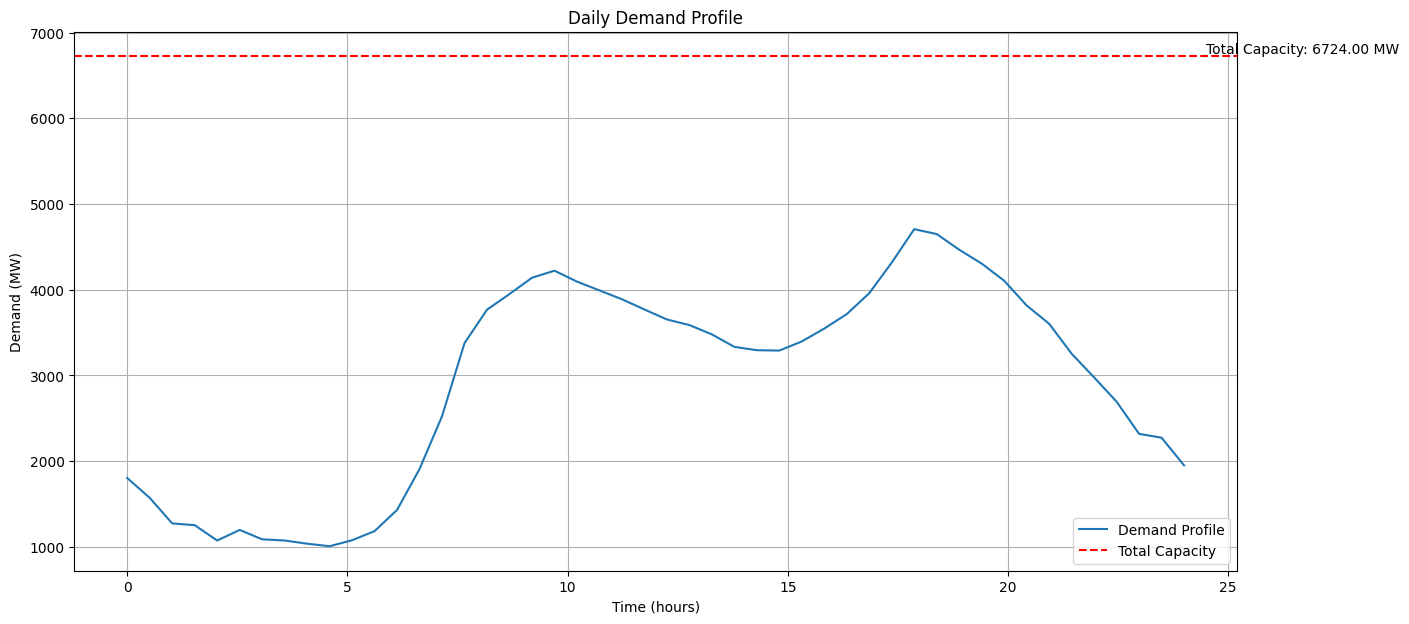

Cost coefficients for each generator:
Generator 0:
  a: 24.8570
  b: 16.9652
  c: 0.0095
Generator 1:
  a: 28.9041
  b: 15.2234
  c: 0.0077
Generator 2:
  a: 6.4080
  b: 13.6769
  c: 0.0026
Generator 3:
  a: 18.0293
  b: 19.4310
  c: 0.0089
Generator 4:
  a: 6.5323
  b: 11.3995
  c: 0.0046
Generator 5:
  a: 6.2846
  b: 12.6145
  c: 0.0015
Generator 6:
  a: 5.6217
  b: 11.8751
  c: 0.0039
Generator 7:
  a: 16.8552
  b: 15.7714
  c: 0.0076
Generator 8:
  a: 7.6233
  b: 14.7063
  c: 0.0042
Generator 9:
  a: 18.6797
  b: 19.4430
  c: 0.0085
Generator 10:
  a: 17.7948
  b: 16.7658
  c: 0.0066
Generator 11:
  a: 8.7159
  b: 14.5900
  c: 0.0012
Generator 12:
  a: 5.3467
  b: 13.8569
  c: 0.0035
Generator 13:
  a: 22.7897
  b: 17.9068
  c: 0.0087
Generator 14:
  a: 18.2216
  b: 16.6686
  c: 0.0055
Generator 15:
  a: 21.9055
  b: 18.0768
  c: 0.0062
Generator 16:
  a: 26.1103
  b: 19.4050
  c: 0.0077
Generator 17:
  a: 7.7064
  b: 14.7008
  c: 0.0047
Generator 18:
  a: 25.6591
  b: 17.6002
  c:

In [4]:
data_gen = DataGenerator(num_generators=40, seed=5000, max_percentage=70, min_percentage=15)
data_gen.plot_demand_profile()
data_gen.print_stats()

Iteration 0:
  Energy Gradient Norm = 744.53
  Learning Rate (Delta t) = 72.9622357919861031
  Current Energy = 20.14
  Cost = 2072349.08
  Normalized Cost = 0.31
  Constraint Penalty = 0.00
Iteration 100:
  Energy Gradient Norm = 747.44
  Learning Rate (Delta t) = 68.0521690236458028
  Current Energy = 21.86
  Cost = 2293819.69
  Normalized Cost = 0.31
  Constraint Penalty = 0.00
Iteration 200:
  Energy Gradient Norm = 747.44
  Learning Rate (Delta t) = 68.0032777581631649
  Current Energy = 21.87
  Cost = 2294875.79
  Normalized Cost = 0.31
  Constraint Penalty = 0.00
Iteration 300:
  Energy Gradient Norm = 747.44
  Learning Rate (Delta t) = 67.9882518431410716
  Current Energy = 21.87
  Cost = 2295102.89
  Normalized Cost = 0.31
  Constraint Penalty = 0.00
Converged at iteration 382 with all normalized criteria met


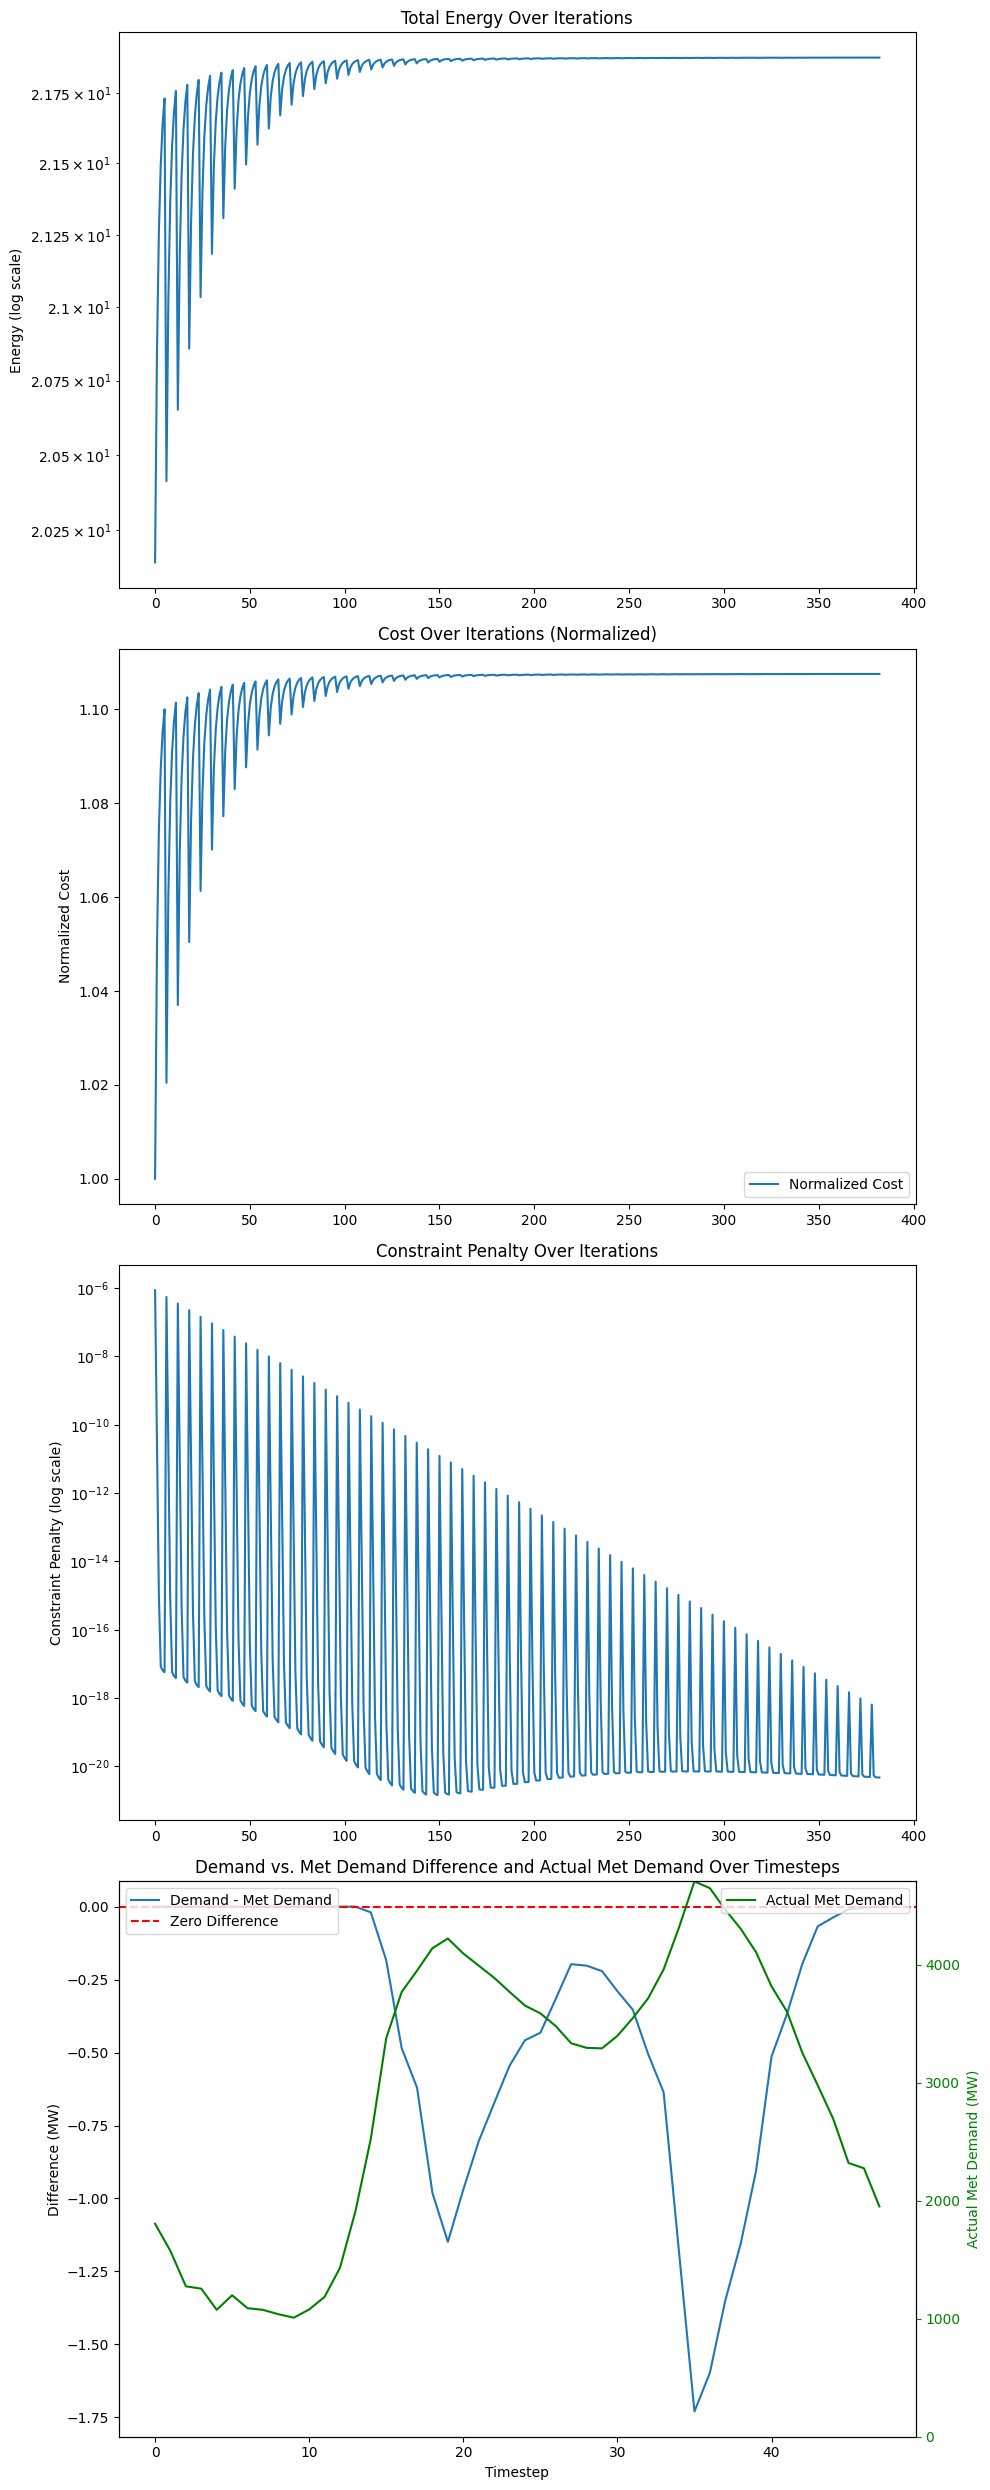

Final Energy: 21.88
Final Cost: 2295230.77
Total Power Generated: 141152.26 MW


In [9]:
hed = HopfieldEconomicDispatch(data_gen, c0=2, dt=0.9, iterations=50000, slow_update_interval=6, interpolation_factor=0.2, beta1=0.95, beta2=0.999, epsilon=1e-8)
solution = hed.solve()

total_power = solution.sum()
print(f"Total Power Generated: {total_power.item():.2f} MW")
